In [1]:
import pandas as pd
import numpy as np
import quantstats as qs
import matplotlib.pyplot as plt

# 動機
- 過去文獻指出，低波動策略因承擔較小的風險，在風險調整後普遍獲得較高的報酬
- 過去實證研究為美股，好奇在台股是否也會有同樣結果
- 參考文獻 : https://www.robeco.com/en-hk/glossary/quantitative-investing/low-volatility-anomaly

# Data
- benchmark : 台灣加權股價指數(Y9999)
- Strategy : 台灣所有上市上櫃公司
- 類別 : 報酬率資料
- 時間 : 2010/01/01 ~ 2023/06/30
- 來源 : TEJ

In [2]:
benchmark = pd.read_csv('Y9999.txt', sep='#', encoding='ANSI', low_memory=False)  # 讀取data
benchmark.columns = ['ticker','name', 'date', 'return']
benchmark['return'] /= 100  # 單位 : % -> 小數
benchmark['date'] = pd.to_datetime(benchmark['date'].astype(str))  # data type -> datetime64 (針對原始data，type(date)要先轉乘成str函數.to_datetime才能正確讀取
benchmark = benchmark.set_index('date')['return']
benchmark.name = 'benchmark'
benchmark

date
2010-01-04    0.002411
2010-01-05    0.000433
2010-01-06    0.014153
2010-01-07   -0.010831
2010-01-08    0.005278
                ...   
2023-06-26   -0.008322
2023-06-27   -0.010044
2023-06-28    0.002826
2023-06-29    0.000394
2023-06-30   -0.001579
Name: benchmark, Length: 3313, dtype: float64

In [3]:
data = pd.read_csv('stock.txt', sep='#', encoding='ANSI', low_memory=False)  # 讀取data
data.columns = ['ticker', 'name', 'date', 'return', 'turnover', 'market_cap(million)']  # 改column名稱
data['return'] /= 100  # 單位 : % -> 小數
data['turnover'] /= 100  # 單位 : % -> 小數
data['ticker'] = data['ticker'].astype(str)  # type(ticker) -> str
data['date'] = pd.to_datetime(data['date'].astype(str))  # data type -> datetime64 (針對原始data，type(date)要先轉乘成str函數.to_datetime才能正確讀取)
data

,ticker,name,date,return,turnover,market_cap(million)
0,1101,台泥,2010-01-04,0.008824,0.002521,112921
1,1102,亞泥,2010-01-04,-0.001445,0.002186,103157
2,1103,嘉泥,2010-01-04,0.016575,0.008018,13208
3,1104,環泥,2010-01-04,0.051429,0.012449,11111
4,1108,幸福,2010-01-04,0.008939,0.008079,3654
...,...,...,...,...,...,...
4978421,9949,琉園,2023-06-30,0.000000,0.000023,705
4978422,9950,萬國通,2023-06-30,-0.051339,0.004478,3564
4978423,9951,皇田,2023-06-30,0.000000,0.001322,5603
4978424,9960,邁達康,2023-06-30,0.008418,0.000893,1006


In [4]:
return_df = data.pivot(index='date', columns='ticker', values='return').copy()  # 調整data方便後續分析(使用copy可以不修改原始data)
return_df

ticker,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.008824,-0.001445,0.016575,0.051429,0.008939,0.014286,0.022026,-0.014908,-0.005825,-0.004261,...,0.017308,0.012911,-0.011194,-0.006098,0.011204,0.007599,0.022508,0.044898,-0.036789,-0.006135
2010-01-05,0.034985,0.021708,-0.005435,-0.016304,-0.007752,0.004695,0.008621,0.001164,-0.001953,0.001427,...,-0.020794,0.001159,-0.003774,-0.003067,0.008310,-0.025641,-0.012579,-0.042969,0.006944,-0.012346
2010-01-06,0.021127,0.007082,-0.016393,0.008287,-0.001116,0.009346,0.012821,0.000000,0.005871,0.017094,...,0.003861,0.011574,-0.011364,-0.004615,0.024725,-0.004644,0.014331,0.024490,0.068966,0.000000
2010-01-07,-0.019310,-0.011252,-0.016667,-0.024658,0.016760,0.004630,-0.004219,-0.002326,-0.011673,-0.016807,...,0.015385,-0.017162,0.000000,-0.020093,0.008043,-0.007776,-0.017268,-0.011952,-0.006452,0.000000
2010-01-08,-0.004219,0.005690,0.014124,0.005618,0.010989,0.000000,0.008475,-0.009324,0.003937,0.008547,...,0.013258,-0.001164,-0.003831,-0.028391,-0.034574,0.006270,-0.001597,0.016129,0.008117,-0.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,0.002584,0.009050,-0.045952,-0.008078,0.002933,-0.005348,-0.013055,0.002463,0.008724,0.001919,...,-0.006944,0.005579,-0.010345,0.000000,0.098361,-0.001316,0.000000,0.004464,-0.001669,0.002513
2023-06-27,-0.009021,-0.006726,-0.020642,0.000000,-0.023392,-0.005376,-0.002646,-0.004914,0.015135,-0.003831,...,0.004662,-0.002774,-0.006969,0.003135,0.084577,-0.014493,-0.002070,0.004444,-0.006689,0.007519
2023-06-28,-0.010403,0.006772,0.009368,-0.001629,0.029940,-0.002703,0.007958,-0.002469,0.011715,0.013462,...,-0.018561,0.005563,0.000000,0.000000,0.009174,0.004011,0.000000,0.044248,-0.001684,0.019900


# Strategy

In [5]:
def signal(data:pd.DataFrame, days:int, N:int, min_counts:int=1, min_periods:int=1) -> pd.DataFrame :
    '''
    功能 : 偵測低波動訊號，只賦予data中過去days天波動幅度最小的前N檔股票訊號
    參數 :
        1. data : 日報酬率資料，type=pd.DataFrame，index=date，columns=tickers
        2. days : 要取過去多少天計算波動，type=int
        3. N : 持股數量，固定買進過去波動幅度最小的前N檔股票，type=int
        4. min_counts : 有效股票數目的閾值。若data中當天有效股票數目(非零資料量)<mincount則return nan，default=1，type=int
        5. min_periods : 計算累積波動的閾值。若該股票過去資料量<min_periods則value=nan，default=1，type=int
    輸出 :
        low_vol_signal : 訊號資料，有訊號value<0；無訊號value=0，type=pd.DataFrame
    '''
    # 複製原來的data，避免修改到原data
    data = data.copy()

    # 訊號處理
        # 計算所有股票過去days天累積波動
    cum_std_df = data.rolling(days, min_periods).std()  # type=pd.DataFrame

        # 偵測訊號
    for t in data.index :
        cum_std_df.loc[t,:] = cum_std_df.loc[t,:].rank(ascending=False)  # 賦予當日累積報酬rank(False:數值愈低rank愈大)，type=pd.Series
                                                                         # 使用rank用意 : 
                                                                         # 使用原始信號分配權重可能發生權重過度集中在某幾個股票(離群值)
                                                                         # 為降低風險，將原始信號轉換成rank
                                                                         # 如此一來，既保留原始訊號的大小順序關係，又可以控制住權重不會過度集中
        sorted_cum_std = cum_std_df.loc[t,:].sort_values(ascending=False)  # 排序:高->低，排名愈前面波動愈低，type=pd.Series
        topN1 = sorted_cum_std[N:N+1]  # 選取波動幅度最小的第N+1檔股票，type=pd.Series
        cum_std_df.loc[t,:] = cum_std_df.loc[t,:] - topN1.values  # value>0的股票即為波動度最小的前N檔股票，type=pd.Series

        # 訊號數值
    cum_std_df[ cum_std_df <= 0 ] = 0  # 波動幅度>=第N+1檔股票的signal=0
    low_vol_signal = cum_std_df.fillna(0)  # nan填0

    return low_vol_signal

In [6]:
def normalize(data:pd.DataFrame) -> pd.DataFrame :
    '''
    功能 : 將data進行標準化2010/01/01 ~ 2023/06/30
    參數 :
        data : 欲進行標準化的data，type=pd.DataFrame，index=date，columns=tickers
    輸出 :
        data : 標準化後的data，，type=pd.DataFrame，index=date，columns=tickers
    '''
    # 複製原來的data，避免修改到原data
    data = data.copy()

    # 標準化
    for t in data.index :
        sum_ = data.loc[t,:].sum()  # 計算當天總波動
        sum_ = sum_ if sum_!= 0 else np.nan  # 避免分母(sum_)=0時下行code會報錯
        data.loc[t,:] = data.loc[t,:] / sum_  # 標準化當天各個data

    return data

# Backtest

In [7]:
def calc_turnover_rate(data:pd.DataFrame, weights:pd.DataFrame) -> pd.DataFrame :
    '''
    功能 : 計算投組中每個股票的日週轉率
    參數 : 
        1. data : 日報酬率資料，type=pd.DataFrame，index=date，columns=tickers
        2. weights : 投組權重，type=pd.DataFrame，index=date，columns=tickers
    輸出 :
        firm_turnover_rate : 投組中每個股票的日週轉率，type=pd.DataFrame，index=date，columns=tickers
    '''
    # 複製原來的data和weights，避免修改到原始資料
    data = data.copy()
    weights = weights.copy()

    # 計算每檔股票的週轉率
    weights = weights.fillna(0)  # nan填0避免影響下行code的計算
    weights_drift = weights.shift(1) * ( data.add(1) )
    weights_drift = normalize(weights_drift)  # 標準化，使權重介於0~1
    firm_turnover_rate = (weights_drift - weights).abs()  # 計算週轉率

    return firm_turnover_rate

In [8]:
def backtest(data:pd.DataFrame, weights:pd.DataFrame, transaction_cost:float) :
    '''
    功能 : 回測一組weights的績效
    輸入 :
        1. data : 日報酬率資料(原始data)，type=pd.DataFrame，index=date，columns=tickers
        2. weights : 欲回測的權重，由策略所計算出來，type=pd.DataFrame，index=date，columns=tickers
        3. transaction_cost : 單邊交易成本，台股抓0.002，type=float
    輸出 :
        1. strategy_gross_return : 略策歷史毛報酬，type=pd.Series
        2. strategy_net_return : 略策歷史淨報酬，type=pd.Series
    '''
    # 複製原來的data和weights，避免修改到原始資料
    data = data.copy()
    weights = weights.copy()

    # 交易成本
    firm_turnover_rate = calc_turnover_rate(data, weights)
    firm_transaction_cost = firm_turnover_rate * transaction_cost

    # 計算每檔股票報酬
    firm_gross_return = (weights.shift(1) * data).fillna(0)  # 每檔股票各自的毛報酬(未扣除交易成本)  
            # .shift(1)的原因為weights是用第t期以前的data所計算出來的，記為weights_t；持有股票的各自報酬率發生在t+1時期，記為data_t+1
            # 我們是在第t期收盤後計算策略權重，第t+1期一開盤買進，每檔股票各自報酬_t+1 = weights_t * data_t+1
            # fillna(0) : nan填0
    firm_net_return = firm_gross_return - firm_transaction_cost  # 每檔股票各自的淨報酬(扣除交易成本)

    # 計算策略報酬
    strategy_gross_return = firm_gross_return.sum(axis=1).fillna(0)  # 策略毛報酬(未扣除交易成本)，axis=1針對index(row)方向加總，計算每日策略報酬 
    strategy_net_return = firm_net_return.sum(axis=1).fillna(0)  # 策略淨報酬(扣除交易成本)
    
    return strategy_gross_return, strategy_net_return

In [9]:
low_vol_signal = signal(data=return_df, days=63, N=50, min_counts=100, min_periods=63)  #偵測低波動訊號
low_vol_weights = normalize(data=low_vol_signal)  # 根據訊號決定持有權重(標準化權重到0~1)
low_vol_weights.fillna(0)  # nan填0避免影響到報酬率計算
strategy_gross_return,  strategy_net_return = backtest(data=return_df, weights=low_vol_weights, transaction_cost=0.002)  # 回測低波動策略績效

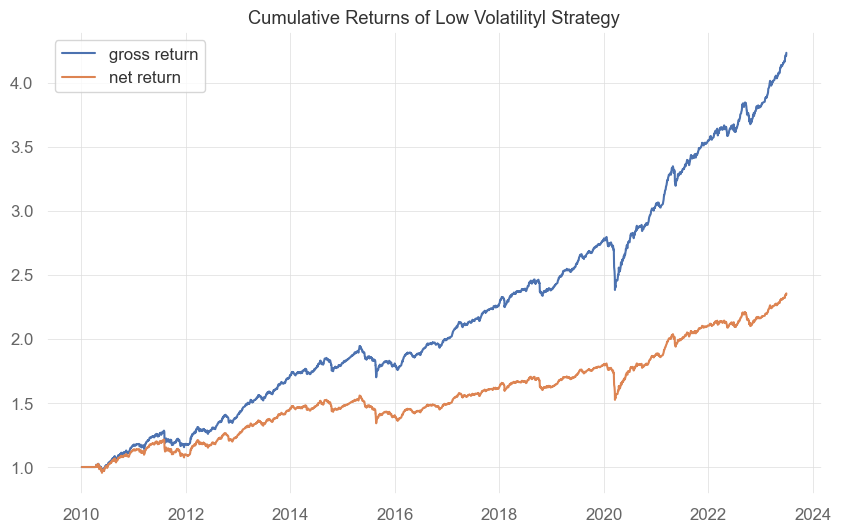

In [10]:
cum_strategy_gross_return = strategy_gross_return.add(1).cumprod()  # 累積毛報酬
cum_strategy_net_return = strategy_net_return.add(1).cumprod()  # 累積淨報酬
plt.title( 'Cumulative Returns of Low Volatilityl Strategy' )
gross_return_plot = plt.plot(cum_strategy_gross_return, label='gross return')  # 累積毛報酬的圖
net_return_plot = plt.plot(cum_strategy_net_return, label='net return')  # 累積淨報酬的圖
plt.legend()

In [11]:
# 毛報酬
gross_mean = strategy_gross_return.mean()*252  # 策略(算數)平均報酬
gross_std = strategy_gross_return.std()*(252**0.5)  # 策略標準差
gross_sharpe = gross_mean / gross_std  # 策略sharpe
gross_series = pd.Series([gross_mean, gross_std, gross_sharpe], index=['annual ret', 'annual std', 'sharpe'])

# 淨報酬
net_mean = strategy_net_return.mean()*252  # 策略(算數)平均報酬
net_std = strategy_net_return.std()*(252**0.5) # 策略標準差
net_sharpe = net_mean / net_std  # 策略sharpe
net_series = pd.Series([net_mean, net_std, net_sharpe], index=['annual ret', 'annual std', 'sharpe'])

pd.DataFrame( { 'gross':gross_series, 'net':net_series } )

,gross,net
annual ret,0.111371,0.066771
annual std,0.055872,0.056220
sharpe,1.993329,1.187678


# 檢驗每日持股數量是否有成功固定住

- 每日訊號數量 = 持有標的數量

In [12]:
low_vol_signal = signal(data=return_df, days=63, N=50, min_counts=100, min_periods=63)  #偵測低波動訊號
low_vol_weights = normalize(data=low_vol_signal)  # 根據訊號決定持有權重(標準化權重到0~1)
low_vol_weights.fillna(0)  # nan填0避免影響到報酬率計算
strategy_gross_return,  strategy_net_return = backtest(data=return_df, weights=low_vol_weights, transaction_cost=0.002)  # 回測低波動策略績效

<Axes: title={'center': 'Daily Signal Count'}, xlabel='date'>

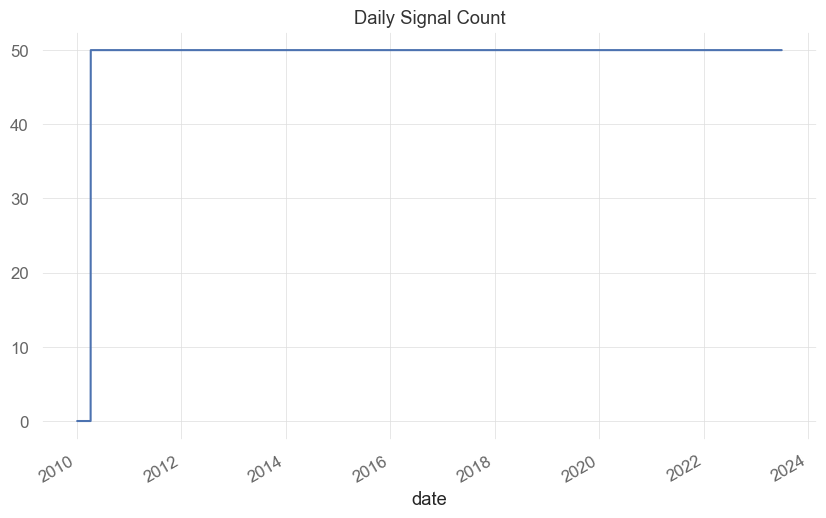

In [13]:
# low_vol_signal>0 -> 買進
(low_vol_signal>0).astype(int).sum(axis=1).plot( title = 'Daily Signal Count' )  # 計算low_vol_signal>0的數量

# 報酬貢獻度分析

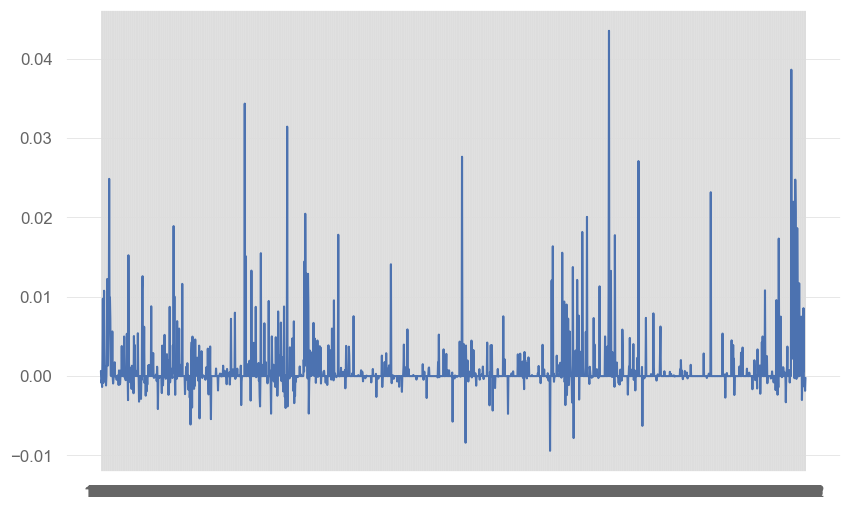

In [14]:
# 依據公司類別進行加總，計算各個股票的總報酬貢獻
firm_total_return = ( return_df * low_vol_weights.shift(1) ).sum(axis=0)
plt.plot( firm_total_return.index, firm_total_return)

In [15]:
# 總報酬貢獻排行(高->低)
firm_total_return.sort_values(ascending=False)

ticker
6184    0.043531
9908    0.038627
2412    0.034352
2616    0.031447
4205    0.027654
          ...   
2006   -0.006103
6294   -0.006275
5608   -0.007808
4413   -0.008399
5386   -0.009417
Length: 1794, dtype: float64

# 參數days分析
- 過去文獻並未指出低波動策略在哪個期間長度表現較優越
- 參數days分析範圍 : 5 ~ 252天，短期 ~ 長期都分析

<Axes: title={'center': 'Sharpe ratio for different time horizons'}, xlabel='time horizons'>

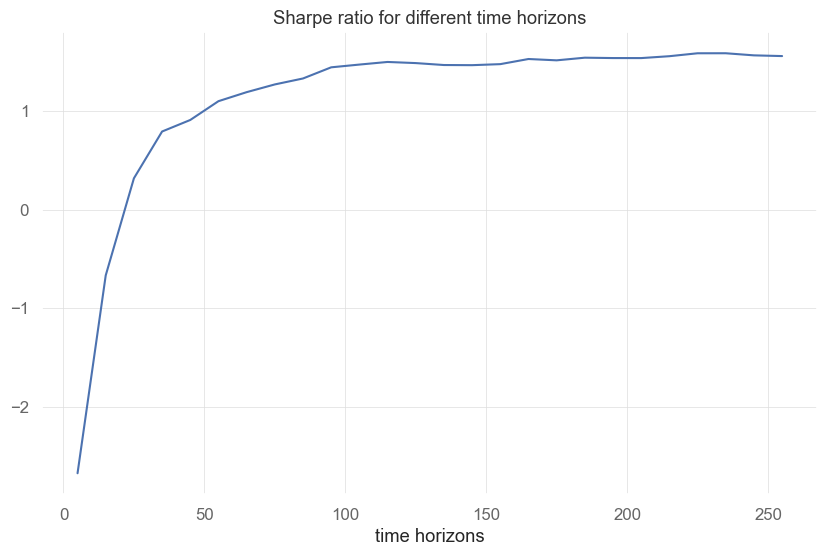

In [16]:
days_list = range(5,262,10)
sharpe_list = []
for d in days_list :
    low_vol_signal_days_temp = signal(data=return_df, days=d, N=50, min_counts=100, min_periods=d)  #偵測低波動訊號
    low_vol_weights_days_temp = normalize(data=low_vol_signal_days_temp)  # 根據訊號決定持有權重
    strategy_gross_return_temp,  strategy_net_return_temp  = backtest(data=return_df, weights=low_vol_weights_days_temp, transaction_cost=0.002)  # 回測低波動策略績效
    net_mean_temp = strategy_net_return_temp.mean()*252  # 策略(算數)平均報酬
    net_std_temp = strategy_net_return_temp.std()*(252**0.5)  # 策略標準差
    net_sharpe_temp = net_mean_temp / net_std_temp  # 策略sharpe
    sharpe_list.append(net_sharpe_temp)
pd.Series(sharpe_list, index = days_list).plot( title = 'Sharpe ratio for different time horizons', xlabel = 'time horizons')

In [17]:
# 依sharpe由大排到小
pd.Series(sharpe_list, index = days_list).sort_values(ascending=False)

235    1.589978
225    1.589733
245    1.568569
255    1.561333
215    1.559990
185    1.544892
195    1.541154
205    1.540874
165    1.531517
175    1.518042
115    1.501526
125    1.490106
155    1.479359
105    1.475004
135    1.470444
145    1.468955
95     1.447093
85     1.333818
75     1.273405
65     1.194907
55     1.103293
45     0.912512
35     0.795362
25     0.320205
15    -0.665363
5     -2.674639
dtype: float64

# 結論
1. 低波動策略在台股也良好的績效，與美股實證研究結論相同
2. 低波動策略在長期表現較好，在參數days=235天時達到最高sharpe ratio = 1.59

# 使用最佳參數設定生成分析圖表

In [18]:
# 最佳參數
opt_days = opt_days = pd.Series(sharpe_list, index = days_list).sort_values(ascending=False).index[0]
opt_days

235

In [19]:
# 使用最佳參數設定生成分析圖表
opt_days = pd.Series(sharpe_list, index = days_list).sort_values(ascending=False).index[0]
low_vol_signal_best = signal(data=return_df, days=opt_days, N = 10, min_counts=100, min_periods=opt_days)  # 偵測低波動訊號
                                                                                                     # 固定只持有過去波動幅度最小的前10檔股票
low_vol_weights_best = normalize(data=low_vol_signal_best)  # 根據訊號決定持有權重(標準化權重到0~1)
low_vol_weights_best.fillna(0)  # nan填0避免影響到報酬率計算
best_strategy_gross_return,  best_strategy_net_return = backtest(data=return_df, weights=low_vol_weights_best, transaction_cost=0.002)  # 回測低波動策略績效

In [20]:
# 使用套件生成一個html檔案，包含精美分析圖表
qs.reports.html(best_strategy_net_return, benchmark=benchmark, output='Strategy performance analysis.html', titile='strategy', download_filename='strategy.html')

C:\Users\Administrator.USER-20180817XC\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Administrator.USER-20180817XC\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Administrator.USER-20180817XC\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future ver